In [1]:
from imports import *

In [2]:
file_path = 'selected_features_PCA.xlsx'
df = pd.read_excel(file_path)
df.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,Irritation
0,-0.156202,0.917365,1.215465,0.378529,0.466241,0.209837,0.232062,0.536511,0.303403,0.196044,1
1,0.133787,0.361076,0.384876,0.713980,0.694891,0.375455,0.234795,0.536740,0.303088,0.201185,1
2,-2.006071,0.000000,1.841560,0.417235,0.459854,0.277571,0.130574,0.724242,0.000000,0.005127,1
3,-0.535903,0.607914,0.648805,0.619348,0.650299,0.287167,0.165618,0.464030,0.396366,0.071052,1
4,-1.577659,0.927894,1.240141,0.480844,0.000000,0.250357,0.112937,0.724242,0.000000,0.028049,1


In [3]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  # Assuming 'Call' is the target variable
y = df['Irritation']

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Print the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (353, 10)
Shape of X_test: (89, 10)
Shape of y_train: (353,)
Shape of y_test: (89,)


In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import optuna

def objective(trial):
    # Define the hyperparameters to tune for RandomForest
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),  # Further reduce n_estimators to avoid too many trees
        "max_depth": trial.suggest_int("max_depth", 3, 7),  # Reduced max depth further
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 20),  # Further increase min_samples_split
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),  # Keep min_samples_leaf moderate
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    }


    # Split the dataset into train, valid, and test sets
    X_t, X_valid, y_t, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(**param)
    
    # Cross-validation to evaluate generalization (not just training accuracy)
    scores_train = cross_val_score(model, X_t, y_t, cv=10, scoring='accuracy')  # Increased to 10-fold cross-validation
    scores_valid = cross_val_score(model, X_valid, y_valid, cv=10, scoring='accuracy')
    
    mean_train = np.mean(scores_train)
    mean_valid = np.mean(scores_valid)
    
    # Custom objective: minimize the difference between train and validation accuracy
    # and maximize the validation accuracy
    overfitting_penalty = np.abs(mean_train - mean_valid)  # Penalize large gaps
    return mean_valid - overfitting_penalty

# Optimize with Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Best parameters
print("Best trial:", study.best_trial.params)

# Train the final model with the best parameters
best_params = study.best_trial.params
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train, y_train)  # Fit on the full training set

# Evaluate final model on the test set
y_pred_final = final_model.predict(X_test)  # You can evaluate on the validation set or test set
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))  # Using validation set here



[I 2025-01-31 10:51:40,507] A new study created in memory with name: no-name-56cd2898-3ab9-4e16-9c34-aaf1be86319d
[I 2025-01-31 10:51:43,750] Trial 0 finished with value: 0.6796031746031747 and parameters: {'n_estimators': 131, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6796031746031747.
[I 2025-01-31 10:51:45,458] Trial 1 finished with value: 0.6596825396825398 and parameters: {'n_estimators': 115, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.6796031746031747.
[I 2025-01-31 10:51:48,240] Trial 2 finished with value: 0.6876984126984128 and parameters: {'n_estimators': 167, 'max_depth': 3, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.6876984126984128.
[I 2025-0

Best trial: {'n_estimators': 102, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False, 'criterion': 'gini'}
Final Model Accuracy: 0.8089887640449438


Final Model Accuracy: 0.8089887640449438


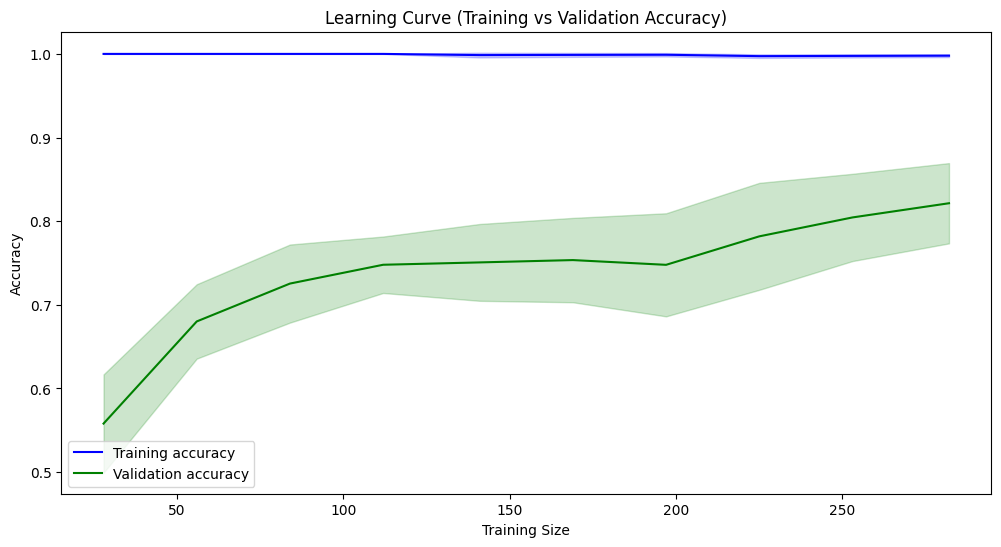

Train Accuracy: 0.9971671388101983
Test Accuracy: 0.8089887640449438


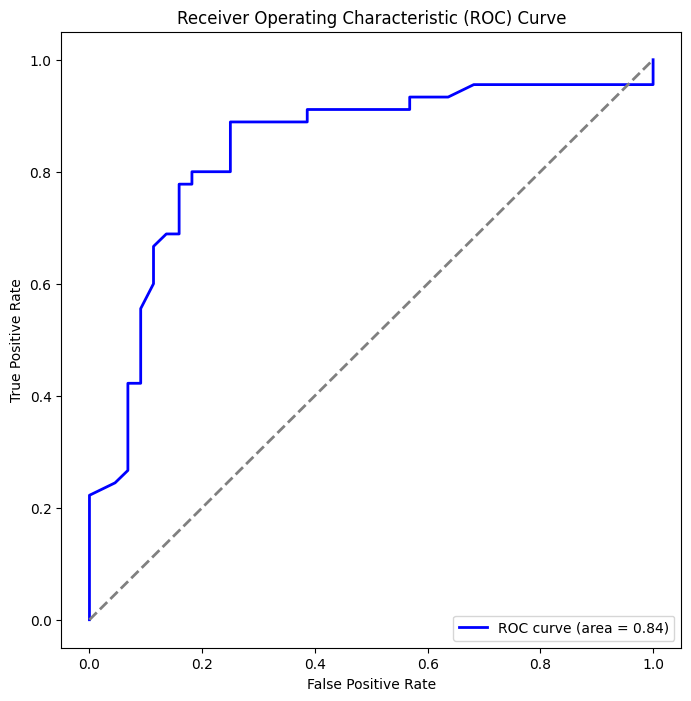

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, learning_curve

# Assuming you already have your study object and X_train, y_train, X_test, y_test
# Get best hyperparameters from study (assuming Optuna tuning)
best_params = study.best_trial.params

# Initialize the RandomForest model with the best parameters
final_model = RandomForestClassifier()

# Train the model
final_model.fit(X_train, y_train)

# Evaluate final model
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy:", accuracy_score(y_test, y_pred_final))

# 1. Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy)')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# 2. ROC Curve Plot
# Calculate ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])  # Get probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
